In [1]:
from torchvision.datasets import Cityscapes 

/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torchvision import transforms
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from PIL import Image, ImageFilter

tsfm_list = [A.HorizontalFlip(p=0.5), A.Affine(scale=(0.9, 1.1), p=0.5), A.RandomBrightnessContrast(p=0.5)]
tsfm_list += [ToTensorV2()]
transforms_fin = A.Compose(tsfm_list, bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))

In [3]:
class CustomTransform:
    def __init__(self):
        tsfm_list = [A.HorizontalFlip(p=0.5), A.Affine(scale=(0.9, 1.1), rotate=(-15,15), 
                            shear=(-4,4), translate_percent={'x':(-0.1, 0.1), 'y':(0, 0.1)}, p=0.75), 
                            A.RandomBrightnessContrast(p=0.5), 
                            # A.Resize(512, 1024),
                            ToTensorV2()]
        self.transforms_fin = A.Compose(tsfm_list)

    def __call__(self, img, target):
        img = (np.array(img)/255.).astype(np.float32)
        tgt = (np.array(target)==23).astype(np.uint8)
        fin = self.transforms_fin(image=img, mask=tgt)
        return fin['image'], fin['mask']

In [4]:
dataset = Cityscapes('/home/kafkaon1/Dev/data/CityScapes', split='train', mode='fine',
                     target_type='semantic', transforms=CustomTransform())

img, smnt = dataset[900]

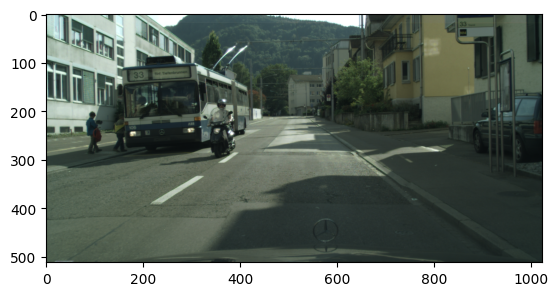

In [5]:
plt.imshow(img.permute(1,2,0))

In [7]:
img.shape

torch.Size([3, 512, 1024])

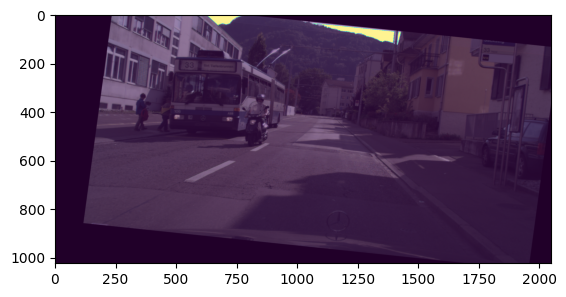

In [115]:
plt.imshow(img.permute(1,2,0))
plt.imshow(smnt, alpha=0.5)

In [48]:
from shapely.geometry import Polygon, Point

import cv2
import numpy as np


def polygon_to_mask(polygon_annotations, image_shape):
    """
    Convert polygon annotations to a mask.

    Parameters:
    polygon_annotations (list of list of tuple): List of polygons, where each polygon is represented by a list of (x, y) tuples.
    image_shape (tuple): Shape of the image (height, width).

    Returns:
    dict: A dictionary with keys 'mask' containing the binary mask and 'annotations' containing the polygon annotations.
    """
    mask = np.zeros(image_shape, dtype=np.uint8)

    for object in polygon_annotations:
        num = 1
        if object['classTitle'] != 'sky':
            num = 2
        polygon = object['points']['exterior']           

        polygon_np = np.array([polygon], dtype=np.int32)
        cv2.fillPoly(mask, polygon_np, num)

    
    return (mask == 1).astype(np.int16)

class SkyDataset(torch.utils.data.Dataset):
    """A PyTorch dataset for sky detection task. Read images, apply augmentation and preprocessing transformations.
    # Args
        type (str): testing or training or validation
    """

    def __init__(self, root_path, split='training', size_coefficient=1, transform=None, **kwargs):
        self.root_path = root_path

        self.transform = transform
        self.coefficient = size_coefficient

        self.img_path = os.path.join(root_path, split, 'img')
        self.names_list = os.listdir( self.img_path)
        self.ann_path = os.path.join(root_path, split, 'ann')



    def __len__(self):
        return int(len(self.names_list)*self.coefficient)

    def __getitem__(self, i):
        image_file_path = os.path.join(self.img_path, self.names_list[i])
        label_file_path = os.path.join(self.ann_path, self.names_list[i] +'.json')

        imageI = Image.open(image_file_path)
        #load ann file from json
        with open(label_file_path) as f:
            label = json.load(f)
        tgt = polygon_to_mask(label['objects'], imageI.size[::-1])
        
        img = (np.array(imageI)/255.).astype(np.float32)
        if self.transform:
            fin = self.transform(image=img, mask=tgt)
            img, tgt =  fin['image'], fin['mask']


        return img, tgt

In [49]:
tsfm_list = [A.HorizontalFlip(p=0.5), A.Affine(scale=(0.9, 1.1), rotate=(-15,15), 
                            shear=(-4,4), translate_percent={'x':(-0.1, 0.1), 'y':(0, 0.1)}, p=0.75), 
                            A.RandomBrightnessContrast(p=0.5), 
                            A.Resize(747, 996),
                            ToTensorV2()]
tsfm = A.Compose(tsfm_list)


dataset = SkyDataset('/home/kafkaon1/Dev/data/mapillary-vistas', split='training', transform=tsfm)
img, smnt = dataset[900]

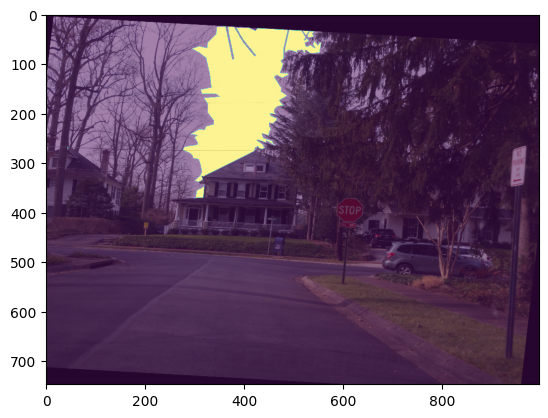

In [53]:
plt.imshow(img.permute(1,2,0))
plt.imshow(smnt, alpha=0.5)

In [22]:
smnt

{'description': '',
 'tags': [],
 'size': {'height': 2988, 'width': 3984},
 'objects': [{'id': 72062344,
   'classId': 6479359,
   'description': '',
   'geometryType': 'polygon',
   'labelerLogin': 'cx@datasetninja.com',
   'createdAt': '2023-10-12T12:06:51.424Z',
   'updatedAt': '2023-10-12T12:06:51.424Z',
   'tags': [{'id': 39490569,
     'tagId': 22887,
     'name': 'void',
     'value': None,
     'labelerLogin': 'cx@datasetninja.com',
     'createdAt': '2023-10-12T12:06:51.424Z',
     'updatedAt': '2023-10-12T12:06:51.424Z'}],
   'classTitle': 'ground',
   'points': {'exterior': [[2676, 1931],
     [2699, 1915],
     [2706, 1904],
     [2710, 1885],
     [2650, 1840],
     [2311, 1852],
     [2163, 1774],
     [2880, 1775],
     [2800, 1936]],
    'interior': []}},
  {'id': 72062343,
   'classId': 6479299,
   'description': '',
   'geometryType': 'polygon',
   'labelerLogin': 'cx@datasetninja.com',
   'createdAt': '2023-10-12T12:06:51.422Z',
   'updatedAt': '2023-10-12T12:06:51.4